<a href="https://colab.research.google.com/github/srinath2022/physics-based-DL/blob/master/AGentleStart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Gentle Start

Let us start by exploring a simple physics problem of predicting the displacement covered by a vertically projected mass in presence of air. For the purpose of this experiment, we consider that the actual dynamics of the projected mass are modelled by the equations described below which account for resistance of the medium. We will generate ground truth data by applying above motion equations, then assuming we have no knowledge of the actual(with air resistance) dynamics, we perform experiments to predict the displacement in **only physics**, **only deep learning** and **physics + deep learning** setting.


$v_{term} = \sqrt{\frac{mg}{c}}$, where $c = \frac{π}{16}\rho D^2$

For the forward motion from the ground to the top (Ascent)

<!-- $v_t = u_0 - v_{term} tan\left(\frac{gt}{v_{term}}\right)$ -->

$s_t = u_0t + \frac{v_{term}^2}{g} ln\left(cos\left(\frac{gt}{v_{term}}\right)\right) $

$T_{ascent} = \frac{v_{term}}{g} tan^{-1}\left(\frac{u_0}{v_{term}}\right)$

For the return motion from the top to the ground (Descent)

<!-- $v_t = -v_{term} tanh\left(\frac{g(t-T_{ascent})}{v_{term}}\right)$ -->

$s_t = H_{max}-\frac{v_{term}^2}{g} ln\left(cosh\left(\frac{g(t-T_{ascent})}{v_{term}}\right)\right)$

$T_{descent} = \frac{v_{term}}{g} cosh^{-1}\left(e^{\frac{gH_{max}}{v_{term}^2}}\right)$

Total time of flight

$T_{flight} = T_{ascent}+T_{descent}$

**Note :** As ground truth, we consider the quadratic drag model for a projectile from [here](https://dynref.engr.illinois.edu/afp.html) and [here](https://www.physics.udel.edu/~szalewic/teach/419/cm08ln_quad-drag.pdf).

## Setup

The following modules, helper functions are helpful for our experiment throughout this page for visualisation, plots etc. Do not really worry about understanding them right now.

In [1]:
# Import necessary modules
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else  "cpu")
print(device)

cuda:0


In [2]:
# Effective constants
m = 30 # Mass of projectile in grams(g)
g = 9.8 # Acceleration due to gravity in m/s^2
density = 1.225 # Air density is 1.225 kg/m^3
D = 2 # Diameter of the projected object in cm
c = (math.pi/16)*(density)*(D*D)
v_term = math.sqrt((10*m*abs(g))/c)

In [3]:
# Plot the simulation
def plot_simulation(times, velocities, displacements):
  plt.plot(times, velocities)
  plt.plot(times, displacements)
  plt.ylabel('velocity')
  plt.xlabel('time')
  plt.show()

In [4]:
def compare_plot(times, actual, predicted, D_TYPE):
  plt.figure()
  plt.title(f" Plot for {D_TYPE}")
  plt.plot(times, actual, linewidth=2, label='Actual values')
  plt.plot(times, predicted, linewidth=2, label='Predicted')
  plt.ylabel(D_TYPE)
  plt.xlabel('time')
  plt.legend(fontsize=14)
  plt.show()

In [5]:
# Plotting the train loss curve
def loss_plot(epochs, losses):
  plt.figure()
  plt.plot(epochs, losses, 'r')
  plt.ylabel("Loss")
  plt.xlabel('Epoch')
  plt.show()

## The Simulation

We first show a simulation of the proposed particle mass using the above equations for a given initial velocity to get an idea of how the displacement varies with time. We will first calculate the time of flight($T_{flight}$) for the particle, then record displacement covered at each time step starting from $t=0$ to $T_{flight}$ in step sizes of $\frac{1}{5}s$.

In [6]:
def time_of_flight(u_initial, medium):
  if medium=='VACCUM':
    return 2*u_initial/(g)
  elif medium=='AIR_QUADRATIC_DRAG':
    T_ascent = (v_term/g)*math.atan(u_initial/v_term)
    H_max = u_initial*T_ascent + ((v_term*v_term)/g)*math.log(math.cos((g*T_ascent)/v_term))
    T_descent = (v_term/g)*math.acosh(math.exp((g*H_max)/(v_term*v_term)))
    T_flight = T_ascent+T_descent
    return T_flight
  else:
    return "UNK"

# Velocity of the particle at time step T. Initial velocity of the particle is u.
def velocity_t(u_initial, t, medium):
  if medium=='VACCUM':
    return u_initial - g*t
  elif medium=='AIR_QUADRATIC_DRAG':
    T_ascent = (v_term/g)*math.atan(u_initial/v_term)
    if t <= T_ascent:
      return u_initial - v_term*math.tan((g*t)/v_term)
    else:
      return u_initial*0.0- v_term*math.tanh((g*(t-T_ascent))/v_term)
  else:
    return "UNK"

# Displacement by the particle
def displacement_t(u_initial, t, medium):
  if medium=='VACCUM':
    return u_initial*t-(1/2)*g*t*t
  elif medium=='AIR_QUADRATIC_DRAG':
    T_ascent = (v_term/g)*math.atan(u_initial/v_term)
    if t <= T_ascent:
      s_t = u_initial*t + ((v_term*v_term)/g)*math.log(math.cos((g*t)/v_term))
      return s_t
    else:
      H_max = u_initial*T_ascent + ((v_term*v_term)/g)*math.log(math.cos((g*T_ascent)/v_term))
      s_t = H_max - ((v_term*v_term)/g)*math.log(math.cosh((g*(t-T_ascent))/v_term))
      return s_t
  else:
    return "UNK"

def simulate_flight(u_initial, medium):
  T =  time_of_flight(u_initial, medium) # time of flight
  t = 0
  times = []
  velocities = []
  displacements = []
  # calculate velocity at evert time step (of one second interval)
  while t <= T:
    v_t = velocity_t(u_initial, t, medium)
    s_t = displacement_t(u_initial, t, medium)
    times.append(t)
    velocities.append(v_t)
    displacements.append(s_t)
    t = t+(1/5)

  return times, velocities, displacements

We have just finished our code for simulation. Let us go ahead and actually generate simulations below. Feel free to modify the initial velocity to get a glance of the diaplacement trends w.r.t time.

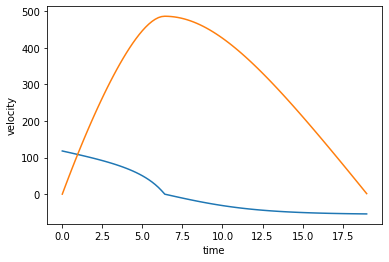

In [7]:
medium = 'AIR_QUADRATIC_DRAG'
u_initial = 117.92
times, velocities, displacements = simulate_flight(u_initial, medium)
plot_simulation(times, velocities, displacements)

## The Data
Now that we have a physics simulation, let us run few simulations and collect the data. i,e we input few random initial velocities, times and get the corresponding displacements during the flight.

For this specific task, let us keep the initial velocities between $0$ to $100$ and time step range betwen $0$ to time of flight $T_{flight}$ 

$$u_0 \in (0, 100)$$

The collected data would look like this, $X, Y$ where
$X = (u, t), Y = (s_t)$   
$u, t$ represent initial velocity and time step, where as $S_t$ represents displacement covered after time $t$.

We will also split the dataset collected into train and test respectively.

In [8]:
# Min and Max of initial velocity (in m/s)
U0_MIN = 0
U0_MAX = 100

def create_data(N_DATA_SAMPLES, D_TYPE, medium, U0_MIN=U0_MIN, U0_MAX=U0_MAX):
  if D_TYPE not in ['VELOCITY', 'DISPLACEMENT', 'VELOCITY_DISPLACEMENT']:
    return
  data = []
  for i in range(N_DATA_SAMPLES):
    u0 = U0_MIN + np.random.rand(1)*(U0_MAX - U0_MIN)
    T   = time_of_flight(u0, medium)
    t   = np.random.rand(1)*T
    v_t = velocity_t(u0, t, medium)
    s_t = displacement_t(u0, t, medium)

    # create a data point
    Y = None
    if D_TYPE=='VELOCITY':
      Y = np.array([v_t])
    elif D_TYPE=='DISPLACEMENT':
      Y = np.array([s_t])
    elif D_TYPE=='VELOCITY_DISPLACEMENT':
      Y = np.array([v_t, s_t])
    else:
      return

    # print(Y)
    datapoint = (np.array([u0, t]), Y)
    data.append(datapoint)

  print("Dataset created!!")
  print("Dataset size", len(data))
  return data

N_DATA_SAMPLES      = 10000
dataset             = create_data(N_DATA_SAMPLES, 'DISPLACEMENT', 'AIR_QUADRATIC_DRAG', 20, 120)
dataset_train       = dataset[:int(N_DATA_SAMPLES*0.8)]
dataset_test        = dataset[int(N_DATA_SAMPLES*0.8):]

Dataset created!!
Dataset size 10000


## Only Physics

We assume that we are not aware of the exact dynamics followed by the particle in the generated data, however we know the equations of motion followed by a particle in vaccum. Using this physics knowledge of ours, let us try to predict the displacement and compare our prediction with the ground truth.

The equations of motion for a vertically projected particle mass in vaccum are as follows.

$S_t = u_0t-\frac{1}{2}gt^2$, where $g \sim 10 \frac{m}{s^2}$

In the following code, we write our prediction function just based on physics, use it to create a simulation and also calculate the loss on the test datset which we have created earlier.

In [9]:
# The physics model
def physics_displacement_t(u_initial, t):
  s_t = u_initial*t - (1/2)*g*t*t
  if s_t<0:
    return 0.0
  return s_t

Let us now compare our predictions with the ground truth by varying the initial velocity.

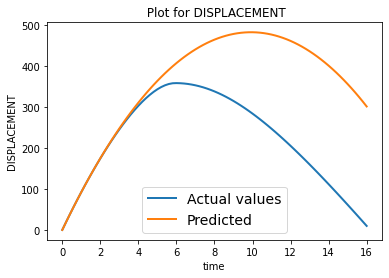

In [10]:
def physics_simulation(u_initial):
  T =  time_of_flight(u_initial, "AIR_QUADRATIC_DRAG")
  t = 0
  times = []
  displacements = []
  while t <= T:
    s_t = physics_displacement_t(u_initial, t)
    times.append(t)
    displacements.append(s_t)
    t = t+(1/5)

  return times, displacements
  
u0 = 97.223
m_times, m_displacements = physics_simulation(u0)
times, velocities, displacements = simulate_flight(u0, "AIR_QUADRATIC_DRAG")
compare_plot(times, displacements, m_displacements, 'DISPLACEMENT')

To get some quantitative estimation and also to compae various methods, we will go ahead and calculate the loss of our physics based prediction w.r.t the ground truth data. We will be using the standard MSE Loss.

In [11]:
def physics_model_loss(test_dataset):
  N = len(test_dataset)
  total_loss = 0.0
  for data_point in test_dataset:
    X, Y = data_point
    prediction = physics_displacement_t(X[0], X[1])
    actual = Y[0]
    loss = (prediction-actual)*(prediction-actual)
    total_loss = total_loss+loss.item()
  
  return total_loss/N

print("Only Physics Loss ", physics_model_loss(dataset_test))

Only Physics Loss  18032.37606143409


## Only Deep Learing

Now, we try to leverage our modern deep learning techniques to predict the displacement. We will use a simple MLP for the prediction. We start by defining the dataset, model and loss employed.

### Dataset, Model and Loss


In [12]:
# Dataset
class PhysicsData(Dataset):
  def __init__(self, data):
    self.data = data
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index):
    return self.data[index]

# Simple model for predicting Displacement
class NewtonNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.nn1 = nn.Linear(in_features=2, out_features=16)
    self.nn2 = nn.Linear(in_features=16, out_features=16)
    self.nn3 = nn.Linear(in_features=16, out_features=1)
    self.relu = nn.ReLU()
    
  def forward(self, x):
    x = self.nn1(x)
    x = self.relu(x)
    x = self.nn2(x)
    x = self.relu(x)
    x = self.nn3(x)
    return x

# Define custom loss
class CustomMSELoss(nn.Module):
  def __init__(self):
    super(CustomMSELoss, self).__init__()
    self.mseLoss = nn.MSELoss()

  def forward(self, Y_predicted, Y_actual, X):
    loss = self.mseLoss(Y_predicted, Y_actual)
    return loss

### Training
Next, we write the appropriate training module to train, test any generic model with specified parameters and train the network on our collected dataset.

In [13]:
# Training
def train(model, train_dataloader, optimizer, criterion, epochs, verbose=False):
  model = model.to(device)
  model.train()

  all_epochs = []
  all_losses = []

  epoch_loss = 0.0
  for epoch in range(epochs):
    epoch_loss = 0.0
    for i, batch in enumerate(train_dataloader):
      X, Y  = batch[0], batch[1]
      X     = torch.transpose(X, 1, 2)
      Y     = torch.transpose(Y, 1, 2)
      X     = X.to(device)
      Y     = Y.to(device)
      Y_predicted = model(X.float())

      optimizer.zero_grad()
      loss = criterion(Y_predicted, Y.float(), X.float())
      epoch_loss = epoch_loss+loss.item()
      loss.backward()
      optimizer.step()

    if verbose:
      print(f"epoch : {epoch+1}, loss : {epoch_loss/len(train_dataloader):.5f}")
    else:
      if epoch%10 == 0:
        print(f"epoch : {epoch}, loss : {epoch_loss/len(train_dataloader):.5f}")

    all_epochs.append(epoch+1)
    all_losses.append(epoch_loss/len(train_dataloader))
  
  print("Done Training!")
  print(f"epoch : {epochs}, loss : {epoch_loss/len(train_dataloader):.5f}")
  return model, all_losses, all_epochs

# Testing
def test(model, test_dataloader, criterion):
  model = model.to(device)
  model.eval()

  total_loss = 0.0
  with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
      X, Y  = batch[0], batch[1]
      X     = torch.transpose(X, 1, 2)
      Y     = torch.transpose(Y, 1, 2)
      X     = X.to(device)
      Y     = Y.to(device)
      Y_predicted = model(X.float())

      loss = criterion(Y_predicted, Y.float(), X.float())
      total_loss = total_loss+loss.item()

  avarage_loss = total_loss/len(test_dataloader)
  print(f"Average loss : {avarage_loss:.5f}")
  return avarage_loss

epoch : 0, loss : 8479.95282
epoch : 10, loss : 6194.43660
epoch : 20, loss : 6163.41603
epoch : 30, loss : 6178.98894
epoch : 40, loss : 6209.79873
epoch : 50, loss : 2306.33343
epoch : 60, loss : 553.49150
epoch : 70, loss : 96.28482
epoch : 80, loss : 63.94182
epoch : 90, loss : 55.52834
Done Training!
epoch : 100, loss : 48.12773


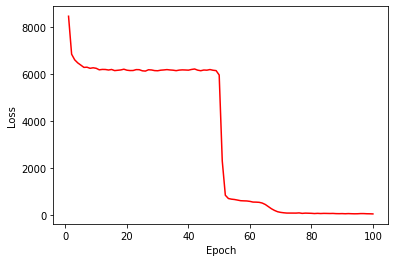

In [14]:
BATCH_SIZE          = 16
model_s             = NewtonNet()
train_dataloader_s  = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
optimizer_s         = optim.Adam(model_s.parameters(), lr = 0.005)
criterion           = CustomMSELoss()
epochs              = 100

model_s, t_loss, t_epochs = train(model_s, train_dataloader_s, optimizer_s, criterion, epochs, verbose=False)
loss_plot(t_epochs, t_loss)

Looks like our training has finished. Let us see how well it performs on the test data.

In [15]:
# Test loss
test_dataloader_s = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)
avg_loss = test(model_s, test_dataloader_s, criterion)

Average loss : 42.08064


### Inference
It is important for us to visualise how our trained model predictions look when compared to the ground truth. So let us write code to infer the displacement from a trained network and use it to generate the entire simulation.

In [16]:
def single_inference(D_TYPE, model, u0, t):
  input   = torch.tensor([[u0, t]])
  input   = input.unsqueeze(0)
  input   = input.to(device)
  output  = model(input.float())
  output  = output.cpu().data.numpy()

  if D_TYPE=='VELOCITY':
    return output[0][0][0], 0
  elif D_TYPE=='DISPLACEMENT':
    return 0, output[0][0][0]
  elif D_TYPE=='VELOCITY_DISPLACEMENT':
    return output[0][0][0], output[0][0][1]
  else:
    return

def simulation_inference(D_TYPE, model, u0, medium):
  model = model.to(device)
  T = time_of_flight(u0, medium) # time of flight
  t = 0
  times = []
  velocities = []
  displacements = []
  # calculate velocity at evert time step (of one second interval)
  while t <= T:
    v_t = None
    s_t = None
    v_t, s_t = single_inference(D_TYPE, model, u0, t)
    times.append(t)
    velocities.append(v_t)
    displacements.append(s_t)
    t = t+(1/5)

  return times, velocities, displacements

Use the following code to test and visualise how our trained model performs w.r.t various initial velocities.

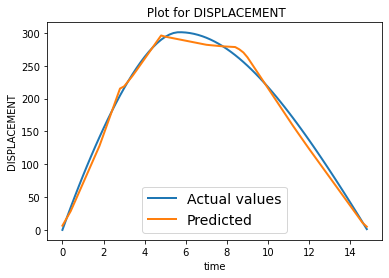

In [17]:
# Run simulation and compare
U_INITIAL = 87.4356
times_p, velocities_p, displacements_p  = simulation_inference('DISPLACEMENT', model_s, U_INITIAL, 'AIR_QUADRATIC_DRAG')
times, velocities, displacements        = simulate_flight(U_INITIAL, 'AIR_QUADRATIC_DRAG')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

## Physics + Deep Learning
As we have tried both physics based approach as well as deep learning based appraoch. Let us now combine both of them to train a network which used deep learning as well as the physics. One way to induct physics into DL is by adding appropriate loss function, similar to the below one.

### Supervised + Physics based loss

Let us try out including both supervision and physics to guide our learning. We will use the following loss function.

$L_{supervised+phy} = (v_{predicted}-v_{actual})^2+(s_{predicted}-s_{actual})^2+\gamma*(v_{predicted}^2-u_{initial}^2-2*g*s_{predicted})^2$

$\gamma$ is used to control weightage given to the physics term.

### Dataset, Model and Loss

Let use define a new model to predict both velocity and displacement, corresponding loss function for this method.

In [18]:
N_DATA_SAMPLES      = 10000
dataset             = create_data(N_DATA_SAMPLES, 'VELOCITY_DISPLACEMENT', 'AIR_QUADRATIC_DRAG', 20, 120)
dataset_train       = dataset[:int(N_DATA_SAMPLES*0.8)]
dataset_test        = dataset[int(N_DATA_SAMPLES*0.8):]

class PhysicsNewtonNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.nn1 = nn.Linear(in_features=2, out_features=16)
    self.nn2 = nn.Linear(in_features=16, out_features=4)
    self.nn3 = nn.Linear(in_features=4, out_features=2)
    self.relu = nn.ReLU()
    
  def forward(self, x):
    x = self.nn1(x)
    x = self.relu(x)
    x = self.nn2(x)
    x = self.relu(x)
    x = self.nn3(x)
    return x

class SupervisedPlusPhysicsBasedLoss(nn.Module):
  def __init__(self, gamma):
    super(SupervisedPlusPhysicsBasedLoss, self).__init__()
    self.gamma = gamma

  def forward(self, Y_predicted, Y_actual, X):
    v_predicted = Y_predicted[:, :, 0]
    s_predicted = Y_predicted[:, :, 1]
    u_initial = X[:, :, 0]
    v_square_from_s = torch.add(torch.square(u_initial), -2*g*s_predicted)
    v_square_from_predicted = torch.square(v_predicted)
    difference = torch.subtract(v_square_from_predicted, v_square_from_s)
    squared_difference = torch.square(difference)

    # supervised v term
    v_actual = Y_actual[:, :, 0]
    difference_v = torch.subtract(v_predicted, v_actual)
    squared_difference_v = torch.square(difference_v)

    # supervised s term
    s_actual = Y_actual[:, :, 1]
    difference_s = torch.subtract(s_predicted, s_actual)
    squared_difference_s = torch.square(difference_s)

    sqr_diff_sum = torch.add(squared_difference_v, squared_difference_s)
    sqr_diff_sum = torch.add(sqr_diff_sum, self.gamma*squared_difference)

    loss = torch.sum(sqr_diff_sum)
    loss = loss/X.shape[0]
    return loss

Dataset created!!
Dataset size 10000


### Training

Train the model on exact same data which is used in the Deep Learning method using the new model and new loss defined.

epoch : 0, loss : 9919.27278
epoch : 10, loss : 540.61859
epoch : 20, loss : 238.72540
epoch : 30, loss : 205.75346
epoch : 40, loss : 192.86591
epoch : 50, loss : 187.55922
epoch : 60, loss : 183.59052
epoch : 70, loss : 184.58625
epoch : 80, loss : 178.23121
epoch : 90, loss : 171.50321
Done Training!
epoch : 100, loss : 172.01582


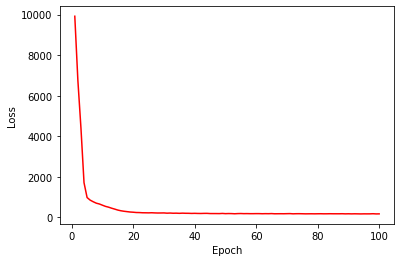

In [28]:
BATCH_SIZE                  = 16
model_v_s_supervisedPhy     = PhysicsNewtonNet()
train_dataloader_v_s        = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
optimizer_v_s_supervisedPhy = optim.Adam(model_v_s_supervisedPhy.parameters(), lr = 0.005)
criterion                   = SupervisedPlusPhysicsBasedLoss(gamma=0.00001)
epochs                      = 100
model_v_s_supervisedPhy, t_loss, t_epochs = train(model_v_s_supervisedPhy, train_dataloader_v_s, optimizer_v_s_supervisedPhy, criterion, epochs)
loss_plot(t_epochs, t_loss)

Calculate the test loss on the test dataset.

In [29]:
# Test loss
test_dataloader_supervisedPhy = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)
avg_loss = test(model_v_s_supervisedPhy, test_dataloader_supervisedPhy, criterion)

Average loss : 158.28286


### Inference

Let us perform a similar inference simulation as done previously to check how close our results are w.r.t ground truth simulation

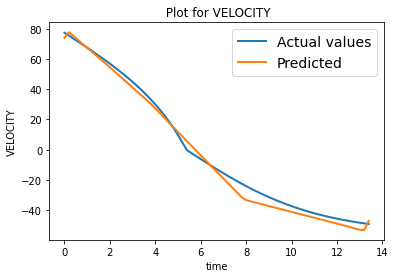

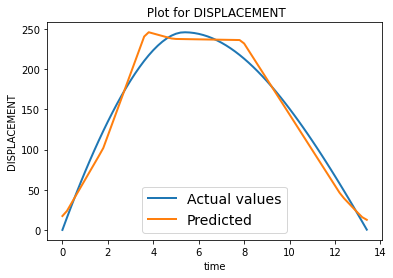

In [30]:
# Run simulation and compare
U_INITIAL = 77.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s_supervisedPhy, U_INITIAL, 'AIR_QUADRATIC_DRAG')
times, velocities, displacements        = simulate_flight(U_INITIAL, 'AIR_QUADRATIC_DRAG')
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

## Comparison
Now that we have seen the three methods for predicting desplacement, Let us try to compare the perfromance of these methods.
The figure below dipicts a plot for comparing the three methods according to the availability of data, showing the test loss trends w.r.t dataset size.

#### Plot-To-Be-Updated

## Conclusion

